In [1]:
import os

from modules import utils
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
import torch
import torch.multiprocessing as mp
from modules.utils import CONFIG_PATH
from modules.data_loader import StaticDataset,DynamicDataset
from torch.utils.data import DataLoader
from modules.models import BPNet_20bit as BPNet
import matplotlib.pyplot as plt
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

## 20bit Static Fully Connected Hamiltonians Infer vs Actual Scatter Plot

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 1 nodes.


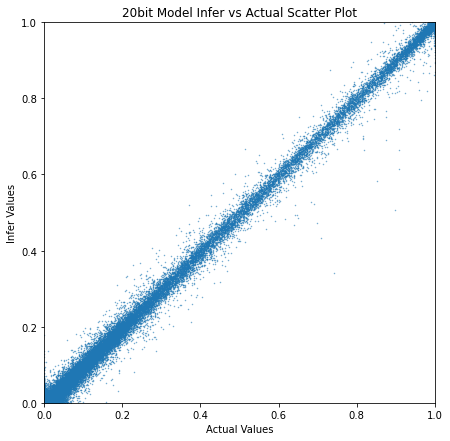

In [2]:
hps = utils.get_hparams(config_path="20bit_config.json")
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = hps.train.port
n_gpus = torch.cuda.device_count()
num_workers = 5 if mp.cpu_count() > 4 else mp.cpu_count()
dist.init_process_group(backend= 'gloo' if os.name == 'nt' else 'nccl', init_method='env://', world_size=n_gpus, rank=0)
test_dataset = StaticDataset(hps, "test") if hps.data.type == "static" else DynamicDataset(hps,"test")
test_loader = DataLoader(test_dataset, num_workers=num_workers, shuffle=False, pin_memory=True,
                             batch_size=hps.infer.batch_size)
model = torch.load(hps.infer.model_dir)  # 读取模型
model = DDP(model, device_ids=[0], find_unused_parameters=True)
model.eval()
inputs, outputs, infers = None, None, None
for batch_idx, items in enumerate(test_loader):
    input_data, output_data = items
    input_data = input_data.cuda(0, non_blocking=True)
    output_data = output_data.cuda(0, non_blocking=True)
    if batch_idx == 0:
        infers = model(input_data)
        inputs = input_data
        outputs = output_data
    else:
        infers = torch.cat([infers, model(input_data)], dim=0)
        inputs = torch.cat([inputs, input_data], dim=0)
        outputs = torch.cat([outputs, output_data], dim=0)
plt.figure(figsize=(7,7))
plt.scatter(outputs.cpu().detach().numpy(),infers.cpu().detach().numpy(),s=0.2,alpha=0.7)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Actual Values')
plt.ylabel('Infer Values')
plt.title('20bit Model Infer vs Actual Scatter Plot')
plt.show()